In [1]:
# from tensorflow.keras.appliications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC,Precision,Recall
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,Tensorboard

from tensorflow.keras.mixed_precision import set_global_policy
import numpy as np
import os

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)


2025-05-05 16:53:56.419001: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 16:53:56.705761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746435236.910562    1128 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746435236.956152    1128 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 16:53:57.229331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
set_global_policy('mixed_float16')
tf.keras.backend.clear_session()

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(0.1, 0.1),
    RandomZoom(0.1),
    RandomRotation(0.05)
])
with tf.device('/GPU:0'):
    base_model = EfficientNetB0(include_top=False, weights='imagenet')
    base_model.trainable = True  

    inputs = layers.Input(shape=(224, 224, 1))
    x = data_augmentation(inputs)
    x = layers.Conv2D(3, (3, 3), padding='same')(x)  
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(7, activation='sigmoid', dtype='float32')(x)  
    model = models.Model(inputs, outputs)

    for layer in base_model.layers[:210]:
        layer.trainable = False

    for i, layer in enumerate(base_model.layers):
        if layer.trainable:
            print(i, layer.name, layer.trainable)

model.summary()


I0000 00:00:1746435262.225525    1128 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1746435262.233321    1128 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


210 block6d_dwconv True
211 block6d_bn True
212 block6d_activation True
213 block6d_se_squeeze True
214 block6d_se_reshape True
215 block6d_se_reduce True
216 block6d_se_expand True
217 block6d_se_excite True
218 block6d_project_conv True
219 block6d_project_bn True
220 block6d_drop True
221 block6d_add True
222 block7a_expand_conv True
223 block7a_expand_bn True
224 block7a_expand_activation True
225 block7a_dwconv True
226 block7a_bn True
227 block7a_activation True
228 block7a_se_squeeze True
229 block7a_se_reshape True
230 block7a_se_reduce True
231 block7a_se_expand True
232 block7a_se_excite True
233 block7a_project_conv True
234 block7a_project_bn True
235 top_conv True
236 top_bn True
237 top_activation True


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,568 (15.48 MB)

 Trainable params: 1,502,853 (5.73 MB)

 Non-trainable params: 2,555,715 (9.75 MB)

In [ ]:
# model.compile(optimizer=Adam(learning_rate=1e-5), loss = "binary_crossentropy", metrics = ["binary_accuracy"])

In [3]:
X_train = np.load("../data/numpy/X_train.npy")
Y_train = np.load("../data/numpy/Y_train.npy")

X_val = np.load("../data/numpy/X_valid.npy")
Y_val = np.load("../data/numpy/Y_valid.npy")

In [ ]:
my_callbacks = [
    ModelCheckpoint(
        monitor = "val_loss" ,# commonly uses valloss why? cuz secret
        verbose =1,
        filepath = "../checkpoint/model3_{epoch:02d}.keras",
        save_best_only = True,
        save_weights_only = False
    ),

    ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 5,
        verbose = 1,
        min_lr = 1e-7
    ),
    EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights =True
    )
    
]

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(4)
# val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(4)



SyntaxError: invalid syntax. Perhaps you forgot a comma? (2450522661.py, line 10)

In [ ]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     # initial_epoch = 31,
#     epochs=25,
#     # batch_size = 8,
#     verbose = 1,
#     callbacks = my_callbacks
# )

In [ ]:

# # Enable async GPU memory allocation and mixed precision
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
# set_global_policy('mixed_float16')
# tf.keras.backend.clear_session()

# # Data augmentation
# data_augmentation = tf.keras.Sequential([
#     RandomFlip("horizontal"),
#     RandomTranslation(0.1, 0.1),
#     RandomZoom(0.1),
#     RandomRotation(0.05)
# ])

# with tf.device('/GPU:0'):
#     inputs = layers.Input(shape=(224, 224, 3))
#     x = data_augmentation(inputs)

#     base_model = EfficientNetB0(include_top=False, weights='imagenet')
#     base_model.trainable = True

#     x = base_model(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     outputs = layers.Dense(7, activation='sigmoid', dtype='float32')(x)  

#     model = models.Model(inputs, outputs)

#     for layer in base_model.layers[:119]:
#         layer.trainable = False

#     for i, layer in enumerate(base_model.layers):
#         if layer.trainable:
#             print(i, layer.name, layer.trainable)

# model.summary()


In [ ]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     # initial_epoch = 31,
#     epochs=25,
#     # batch_size = 8,
#     verbose = 1,
#     callbacks = my_callbacks
# )

In [ ]:
# model.save("../checkpoint/saved2_model.keras")

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['binary_accuracy'], label='train_accuracy')
# plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# model = models.load_model("../checkpoint/model2_23.keras")

In [ ]:
# model.summary()
# print(model.layers[3].summary())

In [ ]:
# # https://keras.io/examples/vision/grad_cam/
# import cv2
# import matplotlib.pyplot as plt

# img_size = (224,224)
# last_conv_layer_name = "top_conv"
# img = cv2.imread("../data/tests/00030786_003.png")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# plt.imshow(img)
# plt.show()


In [21]:

model = models.load_model("../checkpoint/model3_25.keras")

model.compile(optimizer=Adam(learning_rate=1e-5), loss = "binary_crossentropy", metrics = ["binary_accuracy"])

In [6]:
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,568 (15.48 MB)

 Trainable params: 3,707,885 (14.14 MB)

 Non-trainable params: 350,683 (1.34 MB)

In [ ]:
# # model.summary()
# my_callbacks = [
#     ModelCheckpoint(
#         monitor = "val_loss" ,# commonly uses valloss why? cuz secret
#         verbose =1,
#         filepath = "../checkpoint/model3_{epoch:02d}.keras",
#         save_best_only = True,
#         save_weights_only = False
#     ),

#     ReduceLROnPlateau(
#         monitor = "val_loss",
#         factor = 0.5,
#         patience = 5,
#         verbose = 1,
#         min_lr = 1e-7
#     )
#     # EarlyStopping(
#     #     monitor = 'val_loss',
#     #     patience = 5,
#     #     restore_best_weights =True
#     # )
    
# ]


# train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(8)
# val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(8)

In [22]:

# Enable async GPU memory allocation and mixed precision
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

set_global_policy('mixed_float16')

tf.keras.backend.clear_session()


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        initial_epoch = 25,
        epochs=50,
        # batch_size = 8,
        verbose = 1,
        callbacks = my_callbacks
    )

Epoch 26/50


E0000 00:00:1746436889.714977    1128 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3148/3148 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - binary_accuracy: 0.8588 - loss: 0.3320
Epoch 26: val_loss did not improve from 0.32296
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 455s 136ms/step - binary_accuracy: 0.8588 - loss: 0.3320 - val_binary_accuracy: 0.8559 - val_loss: 0.3235 - learning_rate: 1.0000e-05
Epoch 27/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - binary_accuracy: 0.8600 - loss: 0.3306
Epoch 27: val_loss improved from 0.32296 to 0.32280, saving model to ../checkpoint/model3_27.keras
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 481s 153ms/step - binary_accuracy: 0.8600 - loss: 0.3306 - val_binary_accuracy: 0.8584 - val_loss: 0.3228 - learning_rate: 1.0000e-05
Epoch 28/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - binary_accuracy: 0.8600 - loss: 0.3297
Epoch 28: val_loss improved from 0.32280 to 0.31358, saving model to ../checkpoint/model3_28.keras
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 515s 163ms/step - binary_accuracy: 0.8600 - loss: 0.3297 - val_binary_accuracy: 0.8641 - val_loss: 0.3136 - lea

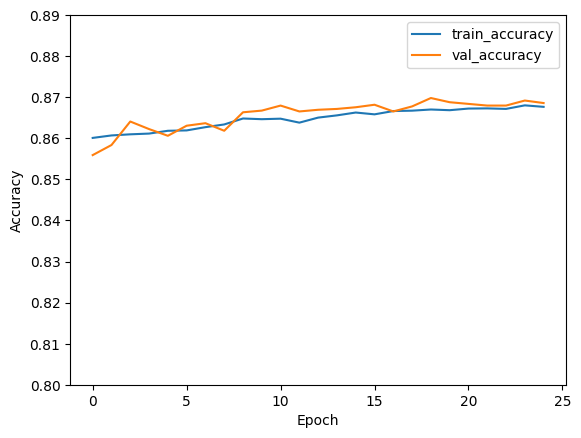

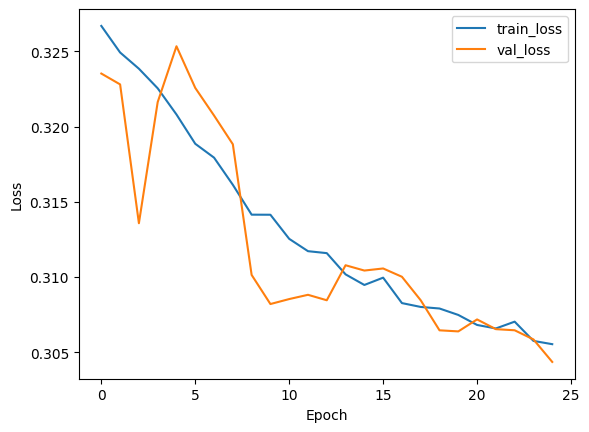

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
# plt.xlim(0,25)
plt.ylim(0.80,.89)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
import pickle

# Save
with open('../history/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [26]:

X_test = np.load("../data/numpy/X_test.npy")
Y_test = np.load("../data/numpy/Y_test.npy")



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

pred_probs = model.predict(X_val)
pred_labels = (pred_probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(Y_val, pred_labels, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(Y_val.argmax(axis=1), pred_labels.argmax(axis=1)))

22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.10      0.17       200
           1       0.42      0.19      0.26        52
           2       1.00      0.03      0.06        30
           3       0.64      0.25      0.36       190
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         9
           6       0.69      0.28      0.39       196

   micro avg       0.64      0.19      0.29       699
   macro avg       0.49      0.12      0.18       699
weighted avg       0.64      0.19      0.28       699
 samples avg       0.19      0.19      0.19       699

Confusion Matrix:
[[177   2   0   9   0   0  12]
 [ 37  10   0   4   0   0   1]
 [ 23   0   1   3   0   0   3]
 [134   4   0  47   0   0   5]
 [ 19   1   0   0   0   0   2]
 [  7   0   0   1   0   0   1]
 [126   7   0  10   0   0  53]]


In [90]:
import cv2
# def get_img_array(img_path, size):
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, size)  # Resize manually
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Keras expects RGB
#     img = img.astype("float32") / 255.0
#     img = np.expand_dims(img, axis=-1) 
#     img = np.expand_dims(img, axis=0) # Add batch dimension

#     return img
def get_img_array(img_path, size):
    # Direct grayscale loading
    img = tf.keras.utils.load_img(img_path, color_mode='grayscale')
    img = img.resize(size)
    array = tf.keras.utils.img_to_array(img)  # Shape (224,224,1)
    array = np.expand_dims(array, axis=0)
    return array / 255.0

# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # base_model = model.get_layer("efficientnetb0")  # This assumes the layer is named "efficientnetb0"
#     # print("Base model input layer name:", base_model.input.name)  # This is the actual input layer for EfficientNetB0
    
#     # for layer in model.layers:
#     #     print(f"Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")
#     # print(model.input.name)

#     # input_tensor = model.input
#     # grad_model = tf.keras.models.Model(
#     #     inputs = input_tensor, outputs = [base_model.get_layer("top_conv").output, model.output]
#     # )

#         # 1) grab your EfficientNet sub‐model
#     effnet = model.get_layer("efficientnetb0")

#     # 2) grab its last conv layer
#     last_conv = effnet.get_layer(last_conv_layer_name)

#     # 3) build a model that maps
#     #      -> your *original* input  — model.inputs
#     #      -> [feature maps @ last_conv, final predictions]
#     grad_model = tf.keras.models.Model(
#         inputs  = model.input,
#         outputs = [last_conv.output, model.output]
#     )

#     # (– now grad_model.inputs[0] will be your original input_layer_1 –)
#     print("Grad‑model input:", grad_model.input.name)
#     # print(grad_model.summary())


#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         # if pred_index is None:
#         #     pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     grads = tape.gradient(class_channel, last_conv_layer_output)

#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()



In [ ]:
# img_array = get_img_array("../data/tests/00030786_003.png", size=(224, 224))  # or (299, 299)
# print(img_array.shape)
# preds = model.predict(img_array) # shape: (num_labels,)

# print(preds)
# threshold = 0.5
# active_labels = np.where(preds > threshold)

# for label_index in active_labels:
#     heatmap = make_gradcam_heatmap(img_array, model, "top_conv", pred_index=label_index)
#     # overlay heatmap or save it

In [31]:
base = model.get_layer("efficientnetb0")
model.summary()
# print(model.input.shape)  

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,474,340 (43.77 MB)

 Trainable params: 3,707,885 (14.14 MB)

 Non-trainable params: 350,683 (1.34 MB)

 Optimizer params: 7,415,772 (28.29 MB)

In [91]:
# https://medium.com/data-science/multi-label-classification-and-class-activation-map-on-fashion-mnist-1454f09f5925
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input

from keras.models import Model
from tensorflow.keras.layers import Conv2D
# get the weights from the last layer
gap_weights = model.layers[-1].get_weights()[0]
# print(gap_weights)
effnet: Model = model.get_layer("efficientnetb0")
# 2) Find its last Conv2D layer by scanning backwards
last_conv = None
for layer in reversed(effnet.layers):
    if isinstance(layer, Conv2D):
        last_conv = layer
        break
print("Using conv layer:", last_conv.name)


# cam_model = Model(inputs = model.input,
#                   outputs =[(model.get_layer('efficientnetb0').get_layer('top_conv').output, model.layers[-1].output)]
#                   )
cam_model = Model(
    inputs=model.input,
    outputs=[ last_conv.output, model.output ]
)
print(cam_model.input.name)

for i,layer in enumerate(cam_model.layers):
    print(i,layer)

# cam_model.summary()
size = (224,224)
arr = get_img_array("../data/tests/00030786_003.png",size)
print(arr.shape)
features, results = cam_model.predict(arr)
# 

Using conv layer: top_conv
input_layer_1
0 <InputLayer name=input_layer, built=True>
1 <Rescaling name=rescaling, built=True>
2 <Normalization name=normalization, built=True>
3 <Rescaling name=rescaling_1, built=True>
4 <ZeroPadding2D name=stem_conv_pad, built=True>
5 <Conv2D name=stem_conv, built=True>
6 <BatchNormalization name=stem_bn, built=True>
7 <Activation name=stem_activation, built=True>
8 <DepthwiseConv2D name=block1a_dwconv, built=True>
9 <BatchNormalization name=block1a_bn, built=True>
10 <Activation name=block1a_activation, built=True>
11 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
12 <Reshape name=block1a_se_reshape, built=True>
13 <Conv2D name=block1a_se_reduce, built=True>
14 <Conv2D name=block1a_se_expand, built=True>
15 <Multiply name=block1a_se_excite, built=True>
16 <Conv2D name=block1a_project_conv, built=True>
17 <BatchNormalization name=block1a_project_bn, built=True>
18 <Conv2D name=block2a_expand_conv, built=True>
19 <BatchNormalization name=b

KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m140438054550416\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 224, 224, 1), dtype=float32)\n  • training=False\n  • mask=None'

In [92]:
# model.summary()
print("Model Input shape: ",model.input_shape)
print("BaseModel Input: ", model.get_layer('efficientnetb0').input_shape)
print("Cam_model shape",cam_model.input_shape)

Model Input shape:  (None, 224, 224, 1)
BaseModel Input:  (None, None, None, 3)
Cam_model shape (None, 224, 224, 1)
